# Graded Challenge 7

Nama: Wilona Natalie Elvaretta  
Batch: RMT-028  
Dataset: [Kaggle](https://www.kaggle.com/datasets/guru001/movie-genre-prediction/data?select=sample_submission.csv)  
Deployment: [HuggingFace](https://huggingface.co/spaces/wilonatalie/p2-ftds028-rmt-g7)  
Model: [NLP](https://drive.google.com/drive/folders/1rWdKxgfGYNyhlGdIW2Au5yn37EwFHBip?usp=sharing)
  
**Problem**:  
Movie genre classification berguna untuk banyak hal, beberapa di antaranya sebagai berikut:
- Filmmaker bisa menguji apakah sinopsis yang mereka draft bisa dikategorikan sebagai genre yang dikehendaki. Jika prediksi tepat, penonton akan mudah untuk menangkap genre film yang ditawarkan hanya dengan membaca sinopsis
- Penonton dimungkinkan untuk melihat genre dari sinopsis, untuk memastikan mereka tidak menonton genre yang tidak diinginkan. Contoh, ada beberapa orang yang sangat menghindari film horor
- OTT platforms mampu mengkategorikan film dengan lebih akurat, dengan mengklarifikasi sinopsis dengan informasi genre yang diberikan

Objektif dari program ini adalah untuk menjadi sarana mengkategorikan film ke genre yang sesuai berdasarkan sinopsisnya, dan diharapkan bisa dipakai oleh berbagai macam pengguna. Model dibuat berdasarkan algoritma Artificial Neural Network (ANN) yang terbaik performanya. Metric yang dipilih untuk menguji performa adalah Accuracy, karena ingin diminimalisir film yang salah diprediksi dan fokus pada model "correctness".

Program diharapkan selesai per tanggal 19 Maret 2024.

## Install/Import Libraries

Library yang diperlukan untuk keberjalanan program di-install/import dengan code di bawah ini.  
Perlu di-note bahwa pembuatan notebook dilakukan dengen Google Colab.

In [1]:
# General use
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Kaggle
! pip install -q kaggle
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Text-related
import re
import string
import nltk
nltk.download('stopwords') # Stopwords
nltk.download('punkt') # Punctuation
nltk.download('wordnet') # Wordnet for lemmatization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

# NN-related
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Bidirectional, Dropout, Reshape
from sklearn.metrics import classification_report

# Data splitting
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading

Data diunduh dari [Kaggle](https://www.kaggle.com/datasets/guru001/movie-genre-prediction/data?select=sample_submission.csv), lalu disimpan ke dalam dataframe.

In [2]:
# Download data from Kaggle
! kaggle datasets download -d guru001/movie-genre-prediction -f train.csv
! unzip train.csv.zip

  0% 0.00/4.11M [00:00<?, ?B/s]
100% 4.11M/4.11M [00:00<00:00, 78.9MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [3]:
# Save downloaded data to csv
df_ori = pd.read_csv('/content/train.csv')
df = df_ori.copy()

Sebagai langkah awal, ditampilkan 5 data awal dan akhir serta informasi ringkas untuk melihat gambaran dataset.

In [4]:
# First 5 data
df.head()

id                                         movie_name  \
0  44978                                           Super Me   
1  50185                                     Entity Project   
2  34131  Behavioral Family Therapy for Serious Psychiat...   
3  78522                                      Blood Glacier   
4   2206                                      Apat na anino   

                                            synopsis    genre  
0  A young scriptwriter starts bringing valuable ...  fantasy  
1  A director and her friends renting a haunted h...   horror  
2  This is an educational video for families and ...   family  
3  Scientists working in the Austrian Alps discov...    scifi  
4  Buy Day - Four Men Widely - Apart in Life - By...   action

In [5]:
# Last 5 data
df.tail()

id                                 movie_name  \
53995  80325  Untitled Monkeyshine/Ugly Brother Project   
53996  84712                          The Great Swindle   
53997  69801                      When Men Get Pregnant   
53998   7678                     Suttu Pidikka Utharavu   
53999  33970                            Margo the Mouse   

                                                synopsis     genre  
53995  Two loser pest control buddies find themselves...     scifi  
53996  A seductive woman gets involved in relationshi...  thriller  
53997  Duyen, a wedding dress staff, who decides to c...   romance  
53998  The people of a crowded colony in Coimbatore c...    action  
53999  Margo is a little mouse that lives quietly in ...    family

In [6]:
# Show data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54000 non-null  int64 
 1   movie_name  54000 non-null  object
 2   synopsis    54000 non-null  object
 3   genre       54000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


- Dataset terdiri dari 54000 baris dan 4 kolom
- Kecuali `id`, kolom merupakan data non-numerik atau teks
- Tidak ditemukan adanya missing values
- Dari judul film, sepertinya ada film yang tidak berbahasa Inggris. Namun, sinopsis yang bersamanya tetap dalam Bahasa Inggris sehingga model ini akan melakukan NLP dengan basis Bahasa Inggris
- Hal yang menarik dari sinopsis yang terlihat di atas adalah adanya nama karakter dan lokasi setting cerita/film, yang membuat sinopsis ini cukup spesifik menggambarkan film. Namun, kata sejenis ini kemungkinan tidak memberi makna tambahan saat modelling
- Banyak genre yang dilibatkan di dataset

In [7]:
# Check duplicated data
df.duplicated().sum()

0

Tidak ada data duplikat pada data.

## Exploratory Data Analysis (EDA): Before Pre-processing

### General

Pertama, ingin dilihat terlebih dahulu bagaimana porsi setiap genre pada dataset.

In [8]:
# Count semua genre
df['genre'].value_counts()

fantasy      5400
horror       5400
family       5400
scifi        5400
action       5400
crime        5400
adventure    5400
mystery      5400
romance      5400
thriller     5400
Name: genre, dtype: int64

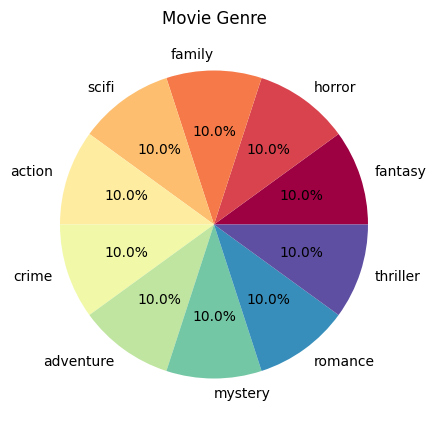

In [9]:
# Pie chart
plt.figure(figsize = (8,5))
df['genre'].value_counts().plot(kind = 'pie', colormap = 'Spectral', autopct = '%.1f%%')
plt.title('Movie Genre')
plt.ylabel('')
plt.show()

Terlihat ada 10 genre di dataset, dan semua genre punya banyak data yang sama.  
Bisa dikatakan data balance sempurna, sehingga tidak perlu dilakukan prosedur untuk balancing.

Karena model yang ingin dibuat adalah memprediksi genre berdasarkan sinopsis, ingin dilihat contoh sinopsis dari masing-masing genre.

In [10]:
# Show sample synopsis for each movie genre
pd.set_option('display.max_colwidth', None)

for genre in df['genre'].unique().tolist():
  print('Sample: ', genre)
  sample = df[df['genre'] == genre].sample(n = 5, random_state = 17)
  print(sample['synopsis'])
  print('-'*150)

Sample:  fantasy
3420                                                                                On her first holiday without her father, Zoey wants to create a magical Christmas for her family just like the ones Mitch used to do.
33796                                                                                                                          Yugi, Jaden and Yusei must travel through time and team up to save a children's card game.
40477    Liza's a nurse, seeking love. Her only company is a long-dead Japanese pop star, who turns her into a fox-fairy out of jealousy. Now, every men who desires Liza shall die horribly. Can she overcome the curse?
46110                                                                                                                        A young thief steals a priceless archaeological treasure that unleashes devastating plagues.
49178          5 protagonists need to find a way to stop a pandemic created by Lucifer. turning humans into dem

Insight:
- Diksi dan jumlah kata sinopsis film sangat beragam. Sinopsis bisa sangat panjang atau pendek
- Tidak terlihat adanya perbedaan panjang sinopsis karena perbedaan genre  
- Semua sampel yang ditampilkan, ditulis dalam Bahasa Inggris
- Ada beberapa kata dari sampel di atas yang sepertinya bukan bagian dari sinopsis yang ditulis filmmakers: See full synopsis, ---KBBO-AINOS. Ini akan ditambahkan sebagai stopwords di bagian text-processing
- Banyak nama karakter dan lokasi setting film yang ditemukan
- Ada kata-kata tertentu yang umumnya memang dikaitkan dengan genre tertentu, seperti 'abandoned' di genre horror, 'disappears' di genre mystery, 'jail' untuk genre crime, dan lain-lain

Selanjutnya, ingin dilihat pola atau keragaman kata di sinopsis film dengan melihat kata yang dominan dengan WordCloud, serta statistik mengenai word count yang terlibat dalam 1 sinopsis.

### Word count

Di bawah ini, ditambahkan panjang sinopsis berdasarkan word count.

In [11]:
# Document length
df['synopsis_length'] = df['synopsis'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

id                                                   movie_name  \
0  44978                                                     Super Me   
1  50185                                               Entity Project   
2  34131  Behavioral Family Therapy for Serious Psychiatric Disorders   
3  78522                                                Blood Glacier   
4   2206                                                Apat na anino   

                                                                                                                                                               synopsis  \
0                         A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.   
1                                              A director and her friends renting a haunted house to capture paranormal events in order to prove it and become popular.   
2  This is an educational video for families and family therapists that describes the Behavioral Family Therapy approach to dealing with serious psychiatric illnesses.   
3                                      Scientists working in the Austrian Alps discover that a glacier is leaking a liquid that appears to be affecting local wildlife.   
4                         Buy Day - Four Men Widely - Apart in Life - By Night Shadows United in One Fight Venting the Fire of their Fury Against the Hated Oppressors.   

     genre  synopsis_length  
0  fantasy               25  
1   horror               22  
2   family               24  
3    scifi               22  
4   action               29

In [12]:
# Display minimum, average and maximum of words
for genre in df['genre'].unique():
  print('Genre: ', genre)
  print('Minimum word count: ', df[df['genre'] == genre]['synopsis_length'].min())
  print('Maximum word count: ', df[df['genre'] == genre]['synopsis_length'].max())
  print('Average word count: ', round(df[df['genre'] == genre]['synopsis_length'].mean(), 2))
  print('-'*100)

Genre:  fantasy
Minimum word count:  2
Maximum word count:  73
Average word count:  29.48
----------------------------------------------------------------------------------------------------
Genre:  horror
Minimum word count:  2
Maximum word count:  76
Average word count:  29.19
----------------------------------------------------------------------------------------------------
Genre:  family
Minimum word count:  1
Maximum word count:  78
Average word count:  29.77
----------------------------------------------------------------------------------------------------
Genre:  scifi
Minimum word count:  3
Maximum word count:  69
Average word count:  28.83
----------------------------------------------------------------------------------------------------
Genre:  action
Minimum word count:  2
Maximum word count:  76
Average word count:  29.0
----------------------------------------------------------------------------------------------------
Genre:  crime
Minimum word count:  2
Maximum word c

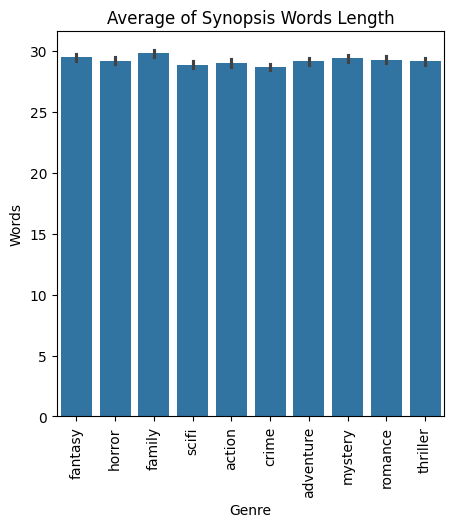

In [13]:
# Barplot
plt.figure(figsize = (5,5))
sns.barplot(data = df, x = 'genre', y = 'synopsis_length')
plt.title('Average of Synopsis Words Length')
plt.xticks(rotation = 90)
plt.ylabel('Words')
plt.xlabel('Genre')
plt.show()

Insight:  
- Word count sinopsis rata-rata sekitar 29 kata. Cukup pendek dan wajar, mengingat sinopsis ini biasanya ditampilkan di web atau OTT dengan size kecil sebagai informasi tambahan. Dan juga, sebisa mungkin penonton tidak terbuang waktunya dengan membaca sinopsis terlalu lama
- Maximum word count berkisar di 60-70 kata, cukup panjang untuk menggambarkan sebuah film secara ringkas
- Minimum word count sinopsis di tiap genre berkisar di 1-3 kata, dicurigai isinya bukanlah tentang film. Mungkin informasi bahwa tidak ada sinopsis yang diberikan filmmaker, dan alasan lainnya

Ingin ditelusuri lebih lanjut seperti apa sinopsis yang hanya dituliskan dengan 1-3 kata.

In [14]:
# Show synopsis with < 4 words
df[df['synopsis_length'] < 4]['synopsis'].value_counts()

Plot undisclosed.                               19
Plot under wraps                                13
Plot Unknown                                     4
Plot Unknown.                                    3
Four Stories.                                    2
Under wraps.                                     1
R RESTRICTED.                                    1
Invasion.                                        1
Texas vampires.                                  1
In development                                   1
NA.                                              1
Undisclosed plot.                                1
kxdhjdixkxjsjsjejrjrjdjxjxjxjxjdjxjxjxixixix     1
The Camerons                                     1
TBA                                              1
Three Stories.                                   1
Plot internal.                                   1
Heidelberg romance.                              1
Faith based                                      1
Under wraps                    

Ternyata ada banyak sinopsis yang belum final atau bahkan tidak ada, sehingga diberi keterangan seperti plot undisclosed, plot under wraps, unknown, dan lain-lain. Jika kata-kata ini di-include sebagai stopwords, bisa jadi suatu film memiliki 0 kata atau tidak memiliki sinopsis.

Oleh karena itu, data dengan sinopsis semacam ini akan di-drop dari dataset di tahap pre-processing.

### Word cloud


Di bawah ini adalah word cloud untuk keseluruhan genre dan per genre.

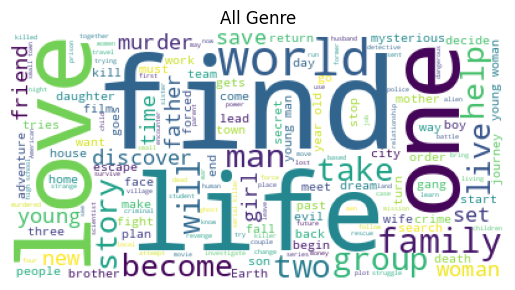

In [15]:
# All genre
text = df['synopsis'].values
wordcloud = WordCloud(background_color="white").generate(" ".join(text))

# Plot word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.title('All Genre')
plt.show()

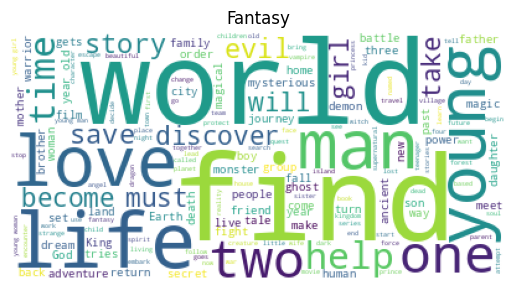

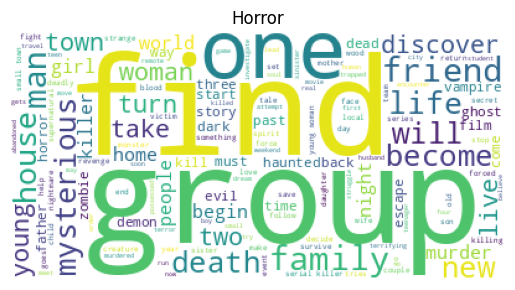

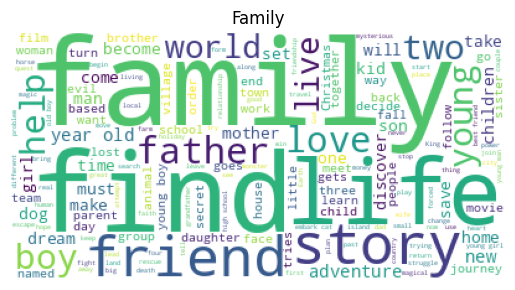

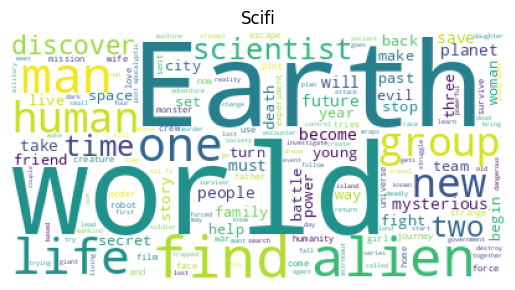

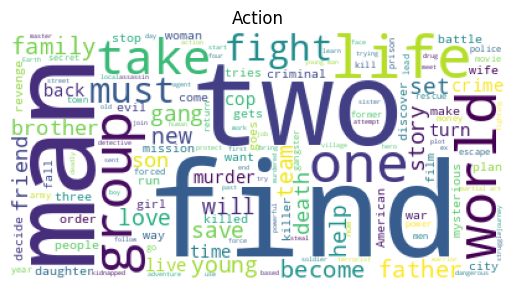

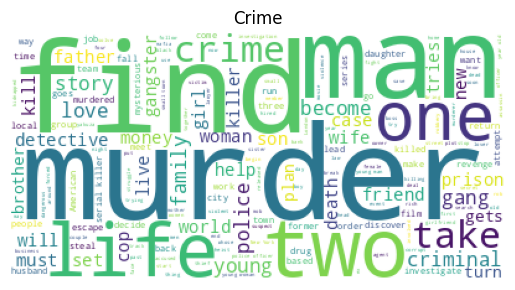

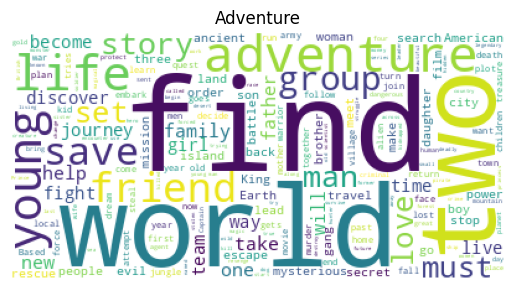

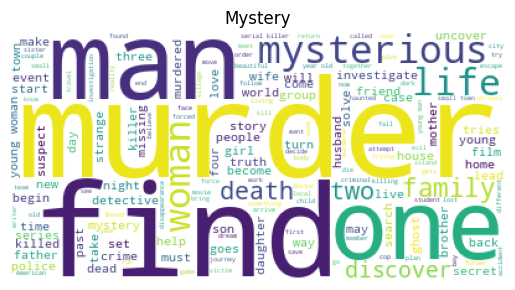

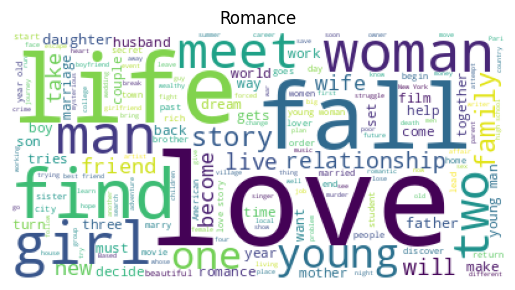

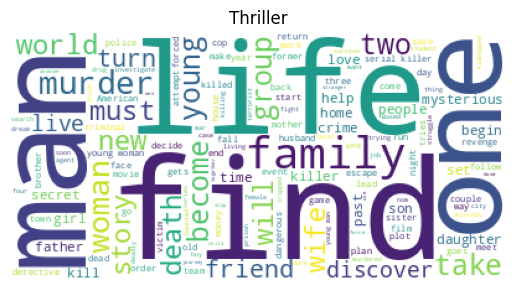

In [16]:
# Each genre
for genre in df['genre'].unique():
  text = df[df['genre'] == genre]['synopsis'].values
  wordcloud = WordCloud(background_color="white").generate(" ".join(text))

  # Plot word cloud
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(genre.capitalize())
  plt.show()

Insight:
- Secara keseluruhan tanpa memandang genre, beberapa kata sering muncul di sinopsis seperti 'find', 'life', dan 'love'. Dapat ditarik ide bahwa apapun genre film-nya, alur cerita akan mengandung 3 aspek ini
- Selalu ada kata yang menggambarkan angka di word cloud, seperti 'one', 'two', dan lainnya. Ini akan menjadi tambahan untuk stopwords, karena tidak menambah makna pada sinopsis
- Dilihat per genre, semua genre film mengandung kata 'find' dan 'life' (mengonfirmasi poin pertama) dan sepertinya cukup sering muncul, melihat ukurannya pada masing-masing word cloud. Untuk kata 'life' tidak muncul sebanyak 'find'
- Terlihat kata-kata yang kaitannya erat dengan genre di masing-masing word cloud, seperti 'father' pada genre family, 'alien' pada scifi, 'murder' pada crime dan mystery, dan lain-lain
- Menarik melihat kata 'group' yang dominan di genre horror dan action. Bisa diartikan bahwa kedua genre film ini kemungkinan besar karakter dengan tim/kelompok. Umumnya memang terjadi di film action, di mana sang hero berjuang bersama kelompok ahlinya
- Kata 'man' cukup besar di genre action, crime, mystery, dan thriller. Lumayan bisa dipahami mengingat memang di dunia nyata, biasanya pemeran utama film dengan genre ini adalah laki-laki. Sedangkan 'woman' atau 'girl' terlihat menonjol di genre romance (walaupun posisinya serupa dengan 'men', yang wajar karena hubungan romansa di film umumnya terjadi antara laki-laki dan perempuan)

## Data Pre-processing

Data inferens ingin diambil dari data asli, sehingga diambil 1 sampel untuk dipisahkan dan dikeluarkan dari data supaya model tidak train dengan data inferens (data leakage).

### Split inference data

In [17]:
# Inference data
df_inf = df.sample(n = 1, random_state = 1)

# Delete inference from dataset
df.drop(df_inf.index, inplace = True)

# Reset data index
df.reset_index(drop = True, inplace = True)
df_inf.reset_index(drop = True, inplace = True)

# Saving inference to csv
df_inf.to_csv('inference.csv', index = False)

### Text pre-processing

Beberapa hal yang harus dirapikan atau dibersihkan dari teks sinopsis:
1. Menghapus data dengan sinopsis belum final/tanpa informasi
2. Case folding (mengubah semua kata ke dalam bentuk lower-case)
3. Menghilangkan angka, karena tidak memberi makna pada sinopsis film
4. Menghilangkan tanda baca/simbol/karakter non-huruf lainnya
5. Menghilangkan whitespace, tabs, dan new line
6. Tokenization, mengubah document menjadi word token

Setelah teks sudah dalam format baik dan tokenization selesai, dilakukan tahap pre-processing yang berkaitan dengan kata-kata dalam teks itu sendiri:
1. Mendefinisikan & menambah stopwords, lalu menghapus dari sinopsis film untuk mendapatkan kata yang penting saja
    - Tambahan stopwords dari EDA: "See full synopsis »", "---KBBO-AINOS", "one", "two", dll
2. Lemmatization untuk mengembalikan kata ke bentuk dasar

Di bawah ini dijalankan text-processing, dan hasilnya disimpan ke kolom `synopsis_processed`.

In [18]:
# Drop rows
df = df[df['synopsis'].str.contains('Plot undisclosed.|Plot under wraps|Plot Unknown|Plot Unknown.|Under wraps|NA.|In development|Undisclosed plot|TBA|Plot internal.|TBD') == False]

# Show synopsis with < 4 words
df[df['synopsis_length'] < 4]['synopsis'].value_counts()

Four Stories.                                   2
Faith based                                     1
Pinky violence.                                 1
YAKUZA GANGSTER THRILLER                        1
Bar Paradise                                    1
Fortune 2.                                      1
British Crime/drama/thriller/heist              1
Three Stories.                                  1
Heidelberg romance.                             1
The Camerons                                    1
kxdhjdixkxjsjsjejrjrjdjxjxjxjxjdjxjxjxixixix    1
Texas vampires.                                 1
Invasion.                                       1
R RESTRICTED.                                   1
Supernatural based                              1
Name: synopsis, dtype: int64

In [19]:
# Define stopwords
stopwords_nltk = list(set(stopwords.words('english')))
stopwords_add = ['See full synopsis', 'KBBO-AINOS', 'one',  'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
stopwords_all = stopwords_nltk + stopwords_add

# Define lemmatizer
lemmatizer = WordNetLemmatizer()

In [20]:
# Define pre-processing function

def text_preprocessing(document):

  # Case folding
  document = document.lower()

  # Number, symbols, punctuations removal (keeping only letters & whitespace)
  document = re.sub('[^a-z\s]+', ' ', document)

  # Remove single character if any
  document = re.sub(r'\s+.\s', ' ', document)

  # Whitespace, tabs, new lines
  document = document.strip()

  # Tokenization
  tokens = word_tokenize(document)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stopwords_all]

  # Lemmatization
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  document = ' '.join(tokens)

  return document

In [21]:
# Pre-process synopsis
df['synopsis_processed'] = df['synopsis'].apply(lambda x: text_preprocessing(x))
df[['synopsis', 'synopsis_processed']].head()

synopsis  \
0                         A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.   
1                                              A director and her friends renting a haunted house to capture paranormal events in order to prove it and become popular.   
2  This is an educational video for families and family therapists that describes the Behavioral Family Therapy approach to dealing with serious psychiatric illnesses.   
3                                      Scientists working in the Austrian Alps discover that a glacier is leaking a liquid that appears to be affecting local wildlife.   
4                         Buy Day - Four Men Widely - Apart in Life - By Night Shadows United in One Fight Venting the Fire of their Fury Against the Hated Oppressors.   

                                                                                                           synopsis_processed  
0                       young scriptwriter start bringing valuable object back short nightmare chased demon selling make rich  
1                                   director friend renting haunted house capture paranormal event order prove become popular  
2  educational video family family therapist describes behavioral family therapy approach dealing serious psychiatric illness  
3                             scientist working austrian alp discover glacier leaking liquid appears affecting local wildlife  
4                                   buy day men widely apart life night shadow united fight venting fire fury hated oppressor

Perbedaan sebelum dan sesudah text-processing terlihat lumayan jelas, contoh:
- Semua sudah dalam lowercase dan hanya memiliki karakter huruf
- Sinopsis 0: 'a' dan 'them' hilang, 'makes' berubah menjadi 'make'
- Sinopsis 1: 'and', 'in', 'it' hilang
- dan lainnya.

## Exploratory Data Analysis (EDA): After Pre-processing

Karena `df` sudah drop beberapa data dengan word count sinopsis < 4, ingin dilihat kembali bagaimana porsi tiap genre pada dataset.

In [22]:
# Count semua genre
df['genre'].value_counts()

crime        5392
family       5381
mystery      5381
romance      5379
fantasy      5375
horror       5374
thriller     5374
adventure    5373
action       5366
scifi        5327
Name: genre, dtype: int64

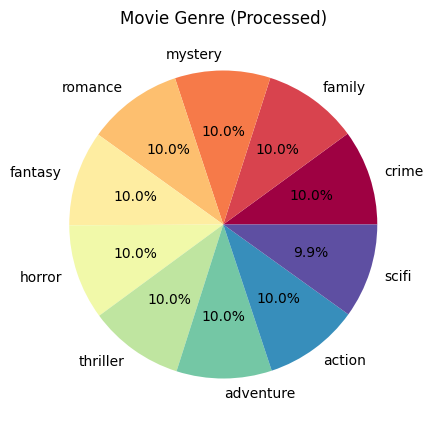

In [23]:
# Pie chart
plt.figure(figsize = (8,5))
df['genre'].value_counts().plot(kind = 'pie', colormap = 'Spectral', autopct = '%.1f%%')
plt.title('Movie Genre (Processed)')
plt.ylabel('')
plt.show()

Ada penurunan data di semua genre (terlihat dari `value_counts()`), dan sekarang genre sci-fi memiliki jumlah observasi yang paling sedikit. Namun, perbedaan jumlah observasi di antara semua genre tetaplah tidak signifikan, sehingga data masih dikategorikan sebagai balanced data.

Ingin dilihat lagi sampel yang sama dengan contoh sebelum pre-processing,  dari tiap genre.

In [24]:
# Show sample synopsis for each movie genre
pd.set_option('display.max_colwidth', None)

for genre in df['genre'].unique().tolist():
  print('Sample: ', genre)
  sample = df[df['genre'] == genre].sample(n = 5, random_state = 17)
  print(sample['synopsis_processed'])
  print('-'*150)

Sample:  fantasy
29712                     early th century pa de calais people mysteriously disappear loute son local fisherman family billie daughter snobbish van peteghems fall love
18522                                                                                   departing ozen camp riko reg continue journey encountering danger descend abyss
47284                      moving south africa care sickly grandmother american girl creates imaginary friend keep company grandmother passing friend mind become enemy
24793    ryo personifies water since whenever something important happens life rain inherits bathhouse meet pyromaniac named yusaku confrontation lead inevitable union
53624                                                   young alice see man look like rabbit claiming late follows stumble bizarre strange world cryptic argentina left
Name: synopsis_processed, dtype: object
-------------------------------------------------------------------------------------------------------

Insight:
- Sinopsis yang sudah diproses terlihat mengandung kata yang jauh lebih sedikit, atau kalimatnya lebih pendek
- Masih ada nama karakter yang ditemukan, karena nama orang memang tidak termasuk dalam stopwords sehingga tidak ter-handle

### Word count

Ingin dilihat bagaimana perbedaan word count setelah sinopsis melalui pre-processing.

In [25]:
# Document length
df['synopsis_processed_length'] = df['synopsis_processed'].apply(lambda x: len(nltk.word_tokenize(x)))

In [26]:
# Show before & after pre-processing synopsis length
pd.DataFrame({'Length of Synopsis (Before)':df['synopsis_length'],
              'Length of Synopsis (After)':df['synopsis_processed_length'],
              'Reduction (%)':round((df['synopsis_length'] - df['synopsis_processed_length'])/df['synopsis_length']*100, 2)
              })

Length of Synopsis (Before)  Length of Synopsis (After)  Reduction (%)
0                               25                          14          44.00
1                               22                          12          45.45
2                               24                          14          41.67
3                               22                          12          45.45
4                               29                          15          48.28
...                            ...                         ...            ...
53994                           17                          10          41.18
53995                           30                          15          50.00
53996                           50                          22          56.00
53997                           32                          16          50.00
53998                           39                          17          56.41

[53722 rows x 3 columns]

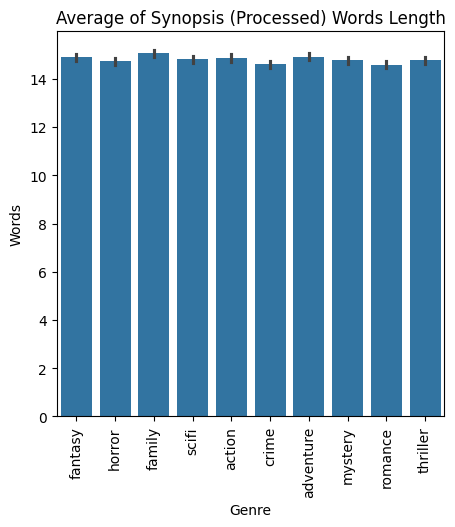

In [27]:
# Barplot
plt.figure(figsize = (5,5))
sns.barplot(data = df, x = 'genre', y = 'synopsis_processed_length')
plt.title('Average of Synopsis (Processed) Words Length')
plt.xticks(rotation = 90)
plt.ylabel('Words')
plt.xlabel('Genre')
plt.show()

Jumlah kata dalam sinopsis sekarang turun jauh angkanya, baik saat dilihat data per data maupun secara rata-rata. Penurunan jumlah kata hampir setengah dari sinopsis, dan ini hal yang baik karena model bisa mempertimbangkan hanya kata-kata yang lebih penting atau bermakna saja

### Word cloud

Word cloud dari sinopsis yang sudah diproses terlihat berbeda, di mana kata yang berukuran besar pada word cloud sebelum pre-processing sekarang menjadi lebih besar lagi atau dapat dikatakan kemunculannya menjadi lebih dominan dari sebelumnya.


Ini menandakan tiap genre punya kata yang terkait erat dengan sinopsis. Akan tetapi kata yang sama ditemukan di genre lainnya (yang palnig jelas adalah 'life'), sehingga pastinya 'life' tidak bisa berkontribusi besar untuk membedakan genre film, akibatnya bisa saja membuat model klasifikasi menjadi kurang baik.

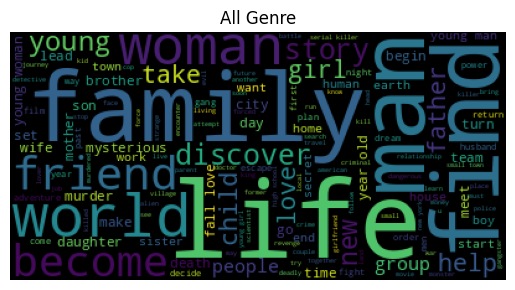

In [28]:
# All genre
text = df['synopsis_processed'].values
wordcloud = WordCloud(background_color="black").generate(" ".join(text))

# Plot word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.title('All Genre')
plt.show()

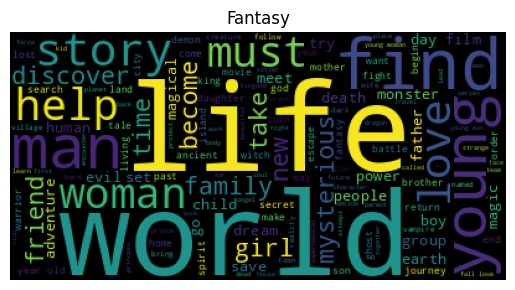

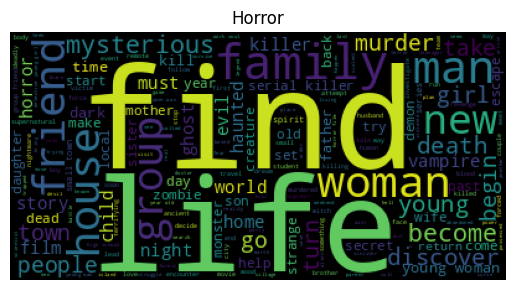

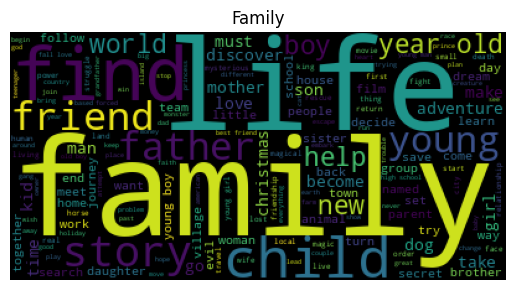

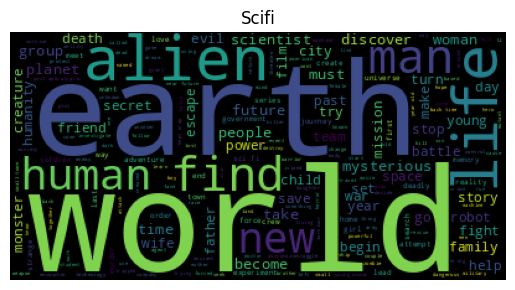

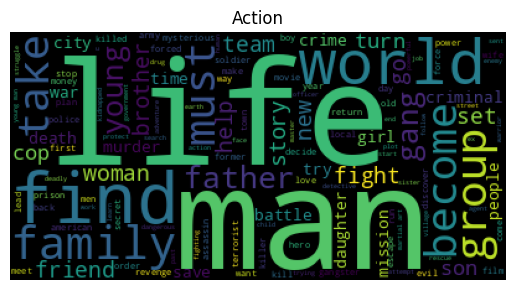

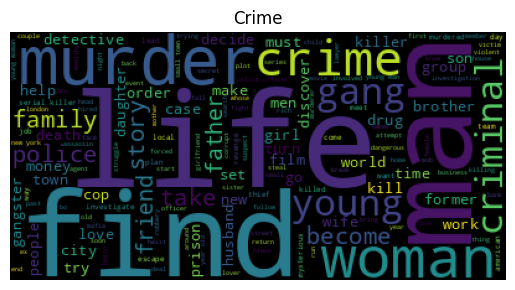

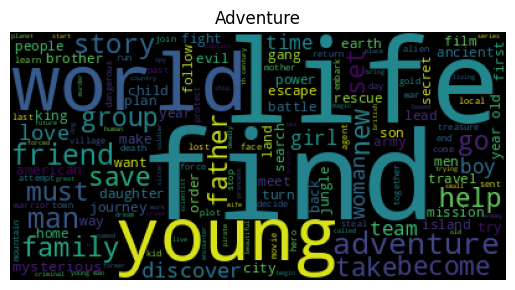

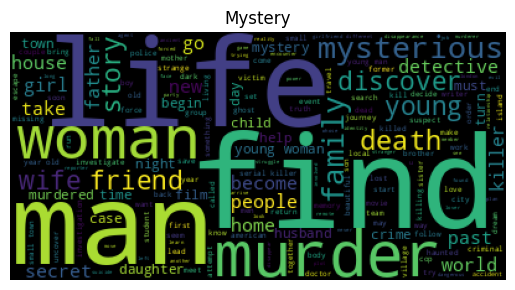

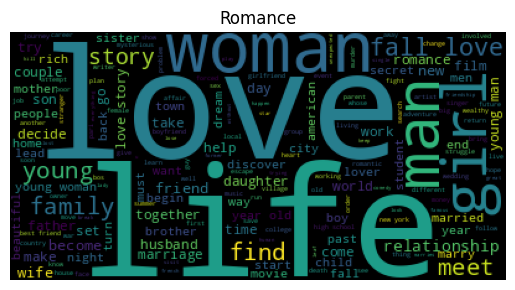

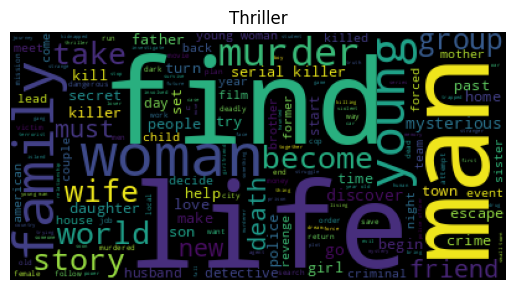

In [29]:
# Each genre
for genre in df['genre'].unique():
  text = df[df['genre'] == genre]['synopsis_processed'].values
  wordcloud = WordCloud(background_color="black").generate(" ".join(text))

  # Plot word cloud
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(genre.capitalize())
  plt.show()

## Modelling

### Target encoding

Genre film terdiri dari 10 kategori, dan ini akan di-encode ke dalam angka agar dapat dibaca oleh model.

In [30]:
# Unique values of genre
df['genre'].unique()

array(['fantasy', 'horror', 'family', 'scifi', 'action', 'crime',
       'adventure', 'mystery', 'romance', 'thriller'], dtype=object)

In [31]:
# Encoding target
df['target'] = df['genre'].replace({
    'fantasy':0,
    'horror':1,
    'family':2,
    'scifi':3,
    'action':4,
    'crime':5,
    'adventure':6,
    'mystery':7,
    'romance':8,
    'thriller':9
})
df[['genre', 'target']].head(10)

genre  target
0    fantasy       0
1     horror       1
2     family       2
3      scifi       3
4     action       4
5     horror       1
6     horror       1
7      crime       5
8  adventure       6
9    mystery       7

### Data splitting

Untuk modelling, data akan dibagi menjadi 3: train set, validation set, dan test set. Validation set memungkinkan kita untuk melihat performa model sebelum diuji dengan data test.

In [32]:
# Train, validation, test set
X_train_val, X_test, y_train_val, y_test = train_test_split(df['synopsis_processed'], df['target'], test_size = 0.15, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, random_state = 1)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (38813,)
Val Size   :  (6850,)
Test Size  :  (8059,)


### Text vectorization

Perlu diingat bahwa komputer tidak mampu membaca kata, sehingga setiap kata harus diterjemahkan ke angka tertentu. Proses ini akan dilakukan dengan TextVectorization.

In [33]:
# Bag of words
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_test)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<38813x34715 sparse matrix of type '<class 'numpy.int64'>'
	with 556628 stored elements in Compressed Sparse Row format>

In [34]:
# Number of vocabs and maximum number of token
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab: ', total_vocab)
print('Maximum Sentence Length: ', max_sen_len, 'tokens')

Total Vocab:  34715
Maximum Sentence Length:  40 tokens


Dari CountVectorizer, terkumpul ada ~34ribu vocabulary dengan maksimum token pada 1 kalimat sinopsis adalah 40 token. Dua angka ini akan menjadi parameter untuk TextVectorization.

Semua vocabulary dilibatkan dalam proses vectorization agar algoritma bisa belajar secara menyeluruh. Sebagai catatan, output dari TextVectorization adalah 70% dari 40, karena secara umum ini dianggap sudah menjadi input yang cukup bagi proses Embedding.

In [35]:
# Text Vectorization
max_sen_len_70 = int(max_sen_len*0.7)
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len_70,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

Di bawah ini adalah 20 vocabulary dengan ranking teratas, di mana kata-kata ini cukup familier karena mereka menonjol pada word cloud.

In [36]:
# Top 20 token
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'young',
 'life',
 'find',
 'man',
 'woman',
 'love',
 'world',
 'family',
 'story',
 'friend',
 'girl',
 'get',
 'new',
 'year',
 'must',
 'take',
 'go',
 'group']

### Word Embedding

Selanjutnya, angka terkait masing-masing kata akan ditransformasi lagi menjadi vektor. Proses ini menambahkan makna pada kata, dan bisa dilihat (jika perlu) bagaimana kemiripan kata secara spesifik.

In [37]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len_70)

### ANN #1

Algoritma yang dipakai adalah LSTM, karena model ini mempertimbangkan konteks yang dibawa oleh masing-masing kata. Layer dalam arsitektur adalah sebagai berikut:
- Input
- Text vectorization
- Embedding
- Bidirectional LSTM
- Dropout (mengurangi input untuk memperbaiki overfitting)
- Hidden
- Output

#### Definition

In [38]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(256, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_1.add(Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_1.add(Dense(10, activation='softmax'))

model_lstm_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

CPU times: user 1.51 s, sys: 34.1 ms, total: 1.54 s
Wall time: 1.58 s


In [39]:
# Model summary
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 28)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 28, 128)           4443520   
                                                                 
 bidirectional (Bidirection  (None, 28, 512)           788480    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 28, 256)           656384    
 onal)                                                           
                                                        

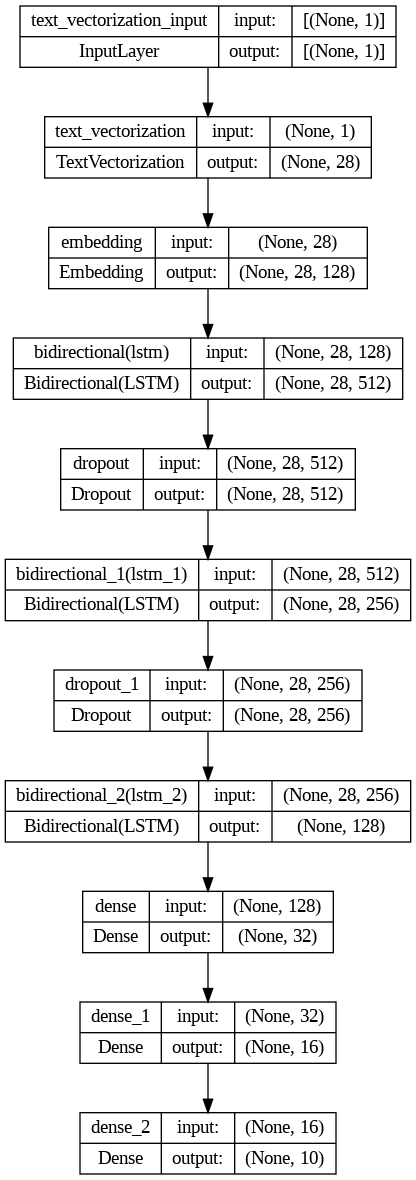

In [40]:
# Plot Layers
tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

#### Training

Training menggunakan epoch 20 agar proses feed-forward dan back propagation cukup sering dilakukan sehingga akurasi dan loss konvergen. Batch size ditentukan 100 untuk menghemat waktu dan komputasi.

In [41]:
# Model training
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train, epochs=20, batch_size = 100, validation_data=(X_val, y_val))

Epoch 1/20
389/389 [==============================] - 37s 62ms/step - loss: 2.1482 - accuracy: 0.1903 - val_loss: 1.9637 - val_accuracy: 0.2940
Epoch 2/20
389/389 [==============================] - 12s 31ms/step - loss: 1.8037 - accuracy: 0.3475 - val_loss: 1.9105 - val_accuracy: 0.3145
Epoch 3/20
389/389 [==============================] - 12s 32ms/step - loss: 1.5684 - accuracy: 0.4439 - val_loss: 1.9595 - val_accuracy: 0.3069
Epoch 4/20
389/389 [==============================] - 15s 40ms/step - loss: 1.3681 - accuracy: 0.5279 - val_loss: 2.1103 - val_accuracy: 0.2978
Epoch 5/20
389/389 [==============================] - 10s 25ms/step - loss: 1.1784 - accuracy: 0.5985 - val_loss: 2.3429 - val_accuracy: 0.2867
Epoch 6/20
389/389 [==============================] - 13s 32ms/step - loss: 1.0137 - accuracy: 0.6570 - val_loss: 2.4726 - val_accuracy: 0.2747
Epoch 7/20
389/389 [==============================] - 10s 25ms/step - loss: 0.8722 - accuracy: 0.7031 - val_loss: 2.8035 - val_accuracy:

#### Evaluation

Dikeluarkan akurasi dan loss untuk train dan validation set.

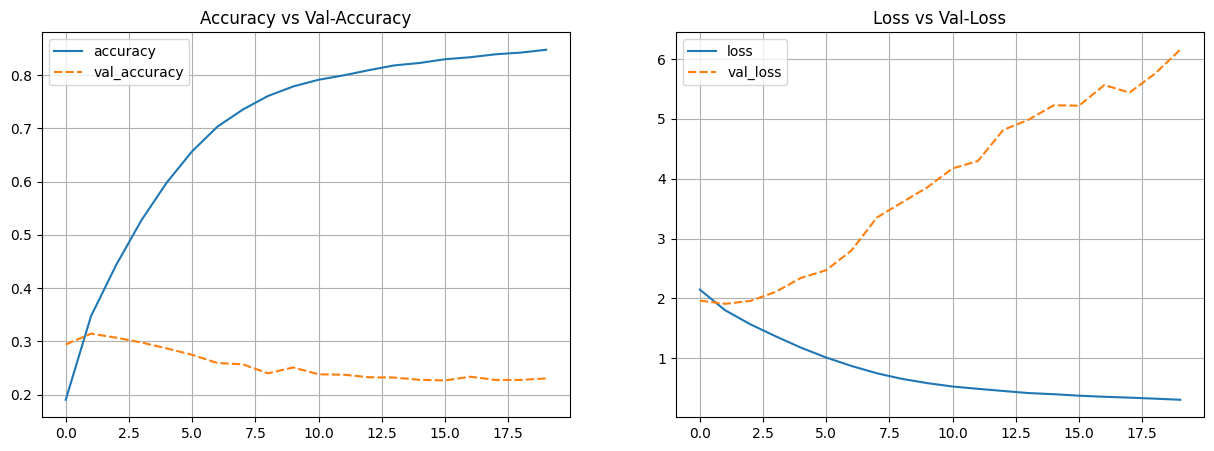

In [42]:
# Plot Training Results
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Terlihat performa model buruk. Sangat overfit, garis akurasi train dan validation sangat jauh dengan akurasi train mendekati 85% dan validation sekitar 23%. Loss untuk validation set juga meningkat seiring majunya epoch, padahal loss train turun. Ini bisa saja disebabkan oleh data validation yang mencakup kata-kata yang tidak dikenal oleh trained model, sehingga model tidak cukup pintar untuk mengenali kata-kata tersebut.

#### Predict

Di bawah ini ditampilkan classification report untuk model pertama.

In [43]:
# Predict
y_pred_lstm_1_proba = model_lstm_1.predict(X_test)
y_pred_lstm_1 = np.argmax(y_pred_lstm_1_proba, axis=-1)

# Display Classification Report
print(classification_report(y_test, y_pred_lstm_1))

252/252 [==============================] - 3s 7ms/step
              precision    recall  f1-score   support

           0       0.18      0.16      0.17       795
           1       0.32      0.31      0.31       798
           2       0.28      0.38      0.32       819
           3       0.32      0.33      0.33       795
           4       0.17      0.16      0.16       828
           5       0.25      0.27      0.26       819
           6       0.17      0.13      0.15       803
           7       0.18      0.15      0.16       813
           8       0.34      0.37      0.36       789
           9       0.12      0.12      0.12       800

    accuracy                           0.24      8059
   macro avg       0.23      0.24      0.23      8059
weighted avg       0.23      0.24      0.23      8059



Accuracy test di angka 24%, buruk juga. Dari F1-score terlihat bahwa genre yang paling mudah dikenali adalah Romance (kelas 8) dan yang paling sulit adalah Thriller (kelas 9).

Dari wordcloud, memang terlihat kategori Thriller punya kata dominan yang muncul juga di genre lain. Dengan kata lain, mungkin sinopsis film-film Thriller tidak memiliki kata unik yang memampukan model mengaitkannya dengan genre itu sendiri.

### ANN #2

Dibuat satu model ANN lainnya, dengan mengurangi hidden layer dan mengurangi neuron pada masing-masing layer.

#### Definition

In [44]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_2.add(Dense(10, activation='softmax'))

model_lstm_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

CPU times: user 1.49 s, sys: 10.5 ms, total: 1.5 s
Wall time: 1.49 s


In [45]:
# Model summary
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 28)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 28, 128)           4443520   
                                                                 
 bidirectional (Bidirection  (None, 28, 256)           263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 28, 128)           164352    
 onal)                                                           
                                                        

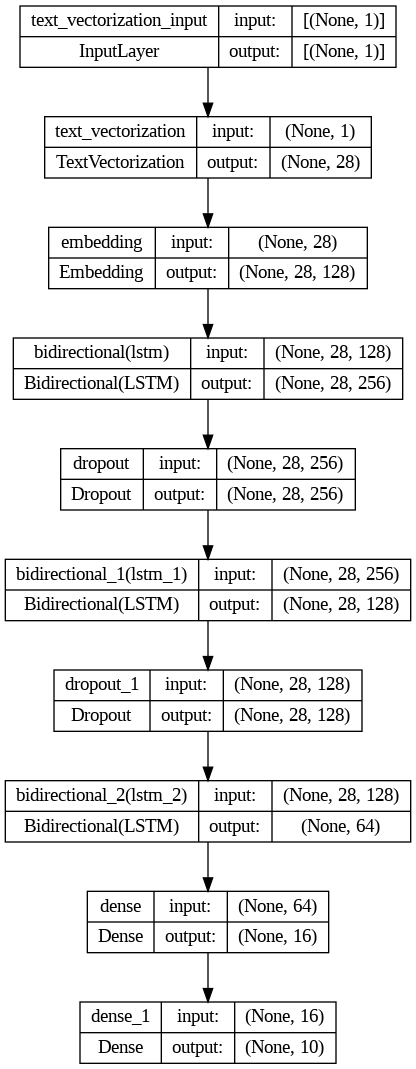

In [46]:
# Plot Layers
tf.keras.utils.plot_model(model_lstm_2, show_shapes=True)

#### Training

In [47]:
# Training
model_lstm_2_hist = model_lstm_2.fit(X_train, y_train, batch_size = 100, epochs = 20, validation_data=(X_val, y_val))

Epoch 1/20
389/389 [==============================] - 34s 62ms/step - loss: 1.1898 - accuracy: 0.5930 - val_loss: 3.0602 - val_accuracy: 0.2434
Epoch 2/20
389/389 [==============================] - 10s 26ms/step - loss: 0.6345 - accuracy: 0.7673 - val_loss: 3.7121 - val_accuracy: 0.2403
Epoch 3/20
389/389 [==============================] - 9s 24ms/step - loss: 0.4839 - accuracy: 0.8043 - val_loss: 4.3757 - val_accuracy: 0.2250
Epoch 4/20
389/389 [==============================] - 8s 20ms/step - loss: 0.4258 - accuracy: 0.8170 - val_loss: 4.6491 - val_accuracy: 0.2255
Epoch 5/20
389/389 [==============================] - 8s 20ms/step - loss: 0.3812 - accuracy: 0.8306 - val_loss: 4.9657 - val_accuracy: 0.2178
Epoch 6/20
389/389 [==============================] - 7s 19ms/step - loss: 0.3572 - accuracy: 0.8341 - val_loss: 5.1082 - val_accuracy: 0.2235
Epoch 7/20
389/389 [==============================] - 7s 19ms/step - loss: 0.3393 - accuracy: 0.8375 - val_loss: 5.2727 - val_accuracy: 0.21

#### Evaluation

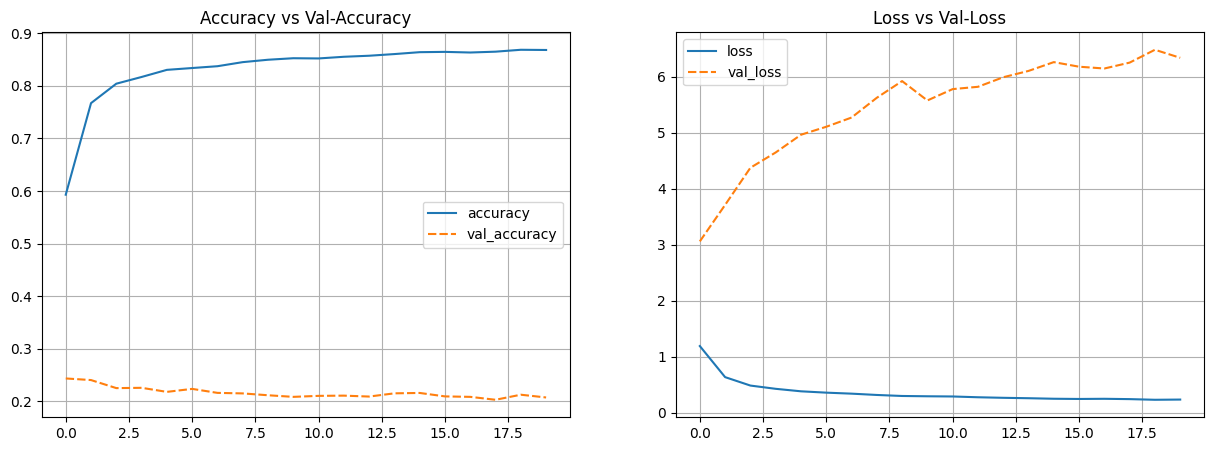

In [48]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Dengan pengurangan layer dan neuron, ternyata model semakin buruk performanya. Namun, perbedaannya tidak signifikan dengan model pertama.

Dapat disimpulkan bahwa jumlah layer dan neuron berpengaruh pada performa model, walaupun pada kasus ini perbedaannya tidak besar.

#### Predict

In [49]:
from sklearn.metrics import classification_report

y_pred_lstm_2_proba = model_lstm_2.predict(X_test)
y_pred_lstm_2 = np.argmax(y_pred_lstm_2_proba, axis=-1)

# Display Classification Report
print(classification_report(y_test, y_pred_lstm_2))

252/252 [==============================] - 3s 6ms/step
              precision    recall  f1-score   support

           0       0.17      0.17      0.17       795
           1       0.28      0.27      0.27       798
           2       0.28      0.26      0.27       819
           3       0.28      0.25      0.26       795
           4       0.17      0.15      0.16       828
           5       0.22      0.30      0.25       819
           6       0.16      0.15      0.16       803
           7       0.16      0.18      0.17       813
           8       0.34      0.34      0.34       789
           9       0.10      0.09      0.09       800

    accuracy                           0.22      8059
   macro avg       0.22      0.22      0.22      8059
weighted avg       0.22      0.22      0.21      8059



Accuracy test di angka 22%, lebih buruk dari model pertama. Dari F1-score terlihat bahwa genre yang paling mudah dikenali adalah Romance (kelas 8) dan yang paling sulit adalah Thriller (kelas 9). Hasil yang sama diperoleh juga di  model pertama.

### Model Saving

Karena performa model pertama lebih baik, `model_lstm_1` disimpan sebagai model NLP final.

In [51]:
# Freeze model
model_lstm_1.trainable = False

# Save model
model_lstm_1.save('model_nlp_final', save_format = 'tf')

### Model Inference

Inferens dilakukan di notebook terpisah, `P2G7_wilona.ipynb`.

## Conclusion

Untuk menjalankan klasifikasi genre, sudah dilakukan langkah-langkah sebagai berikut:
1. Import library yang dibutuhkan
2. Load data yang dipilih dari Kaggle, yaitu data mengenai film
3. Melakukan EDA sebelum menjalankan text-processing, untuk melihat gambaran data secara keseluruhan dan melihat beberapa sampel yang ada
4. Menjalankan text-processing untuk sinopsis, agar document yang masuk ke model sudah bersih dan hanya mengandung kata-kata yang penting saja
5. Melakukan EDA yang kedua kalinya untuk melihat perubahan yang terjadi setelah text-processing
6. Modelling dengan Neural Network, yang mencakup langkah vectorization, embedding, model building
7. Model yang terbaik dipilih berdasarkan akurasi yang tertinggi
Program berjalan dengan baik secara keseluruhan, tanpa error.

Model yang dipilih sebagai model final adalah ANN dengan LSTM dengan arsitektur yang bisa dilihat di bawah ini:

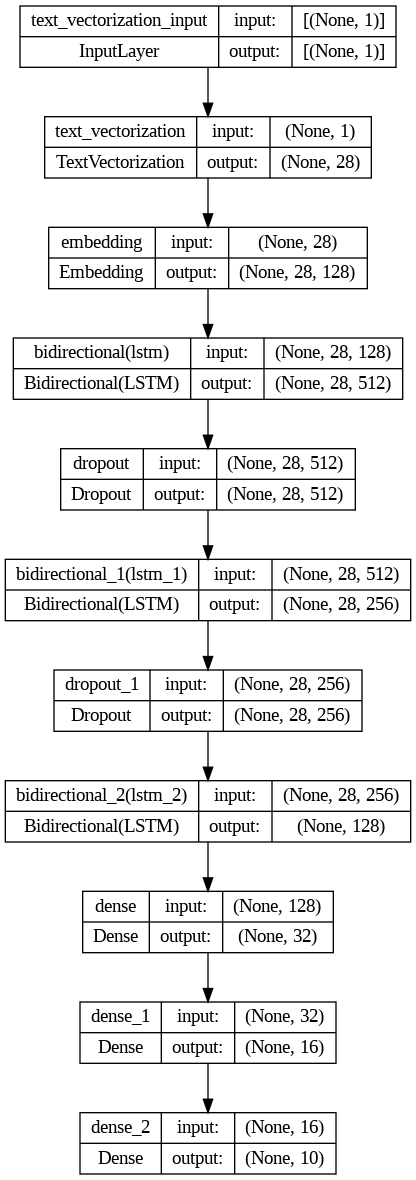

Didapati bahwa mengurangi layer dan neuron menurunkan akurasi, walaupun tidak signifikan. Model final yang dihasilkan akurasinya tidak baik, dan tidak bisa untuk digunakan memprediksi kasus nyata.  

Dicurigai beberapa hal:
- Penulisan sinopsis sangat subjektif, tergantung juga apakah filmmaker mau semacam "merahasiakan" alur film sehingga sinopsis sangat ambigu
- Vocabulary yang dihasilkan sangat banyak, sekitar 34ribu. Bisa jadi text-processing belum menyaring dan membersihkan sinopsis dengan baik, contoh adalah nama karakter film yang seringkali muncul. Karena text-processing belum maksimal, model pun sulit untuk "belajar" membedakan kelas target
- Kata yang ada di sinopsis genre tertentu, muncul di genre lain dan cukup dominan. Bisa menyebabkan model sulit mencari keyword untuk memisahkan kelas target
- Layer yang dilibatkan dalam model kurang banyak dan model LSTM bisa jadi bukan algoritma yang cocok untuk memodelkan dataset ini

Saran memperbaiki model ke depannya:
- Text-processing diperbaiki lagi, jika bisa menghilangkan kata-kata yang tidak perlu seperti nama karakter
- Kata yang dimasukkan ke dalam vocab dibatasi, termasuk yang terlalu sering muncul dan yang jarang sekali muncul. Bisa menggunakan alternatif vectorizer TF-IDF yang mempertimbangkan kedua hal ini
- Memperbanyak jumlah layer dan neuron, atau membuat model deep learning
- Menggunakan transfer learning yang sudah belajar/dilatih dengan dataset lain, atau dengan kata lain sudah terlatih dengan berbagai macam kata seperti BERT
- Mencoba memakai Convolutional Neural Network (CNN) dan juga Recurrent Neural Networks (RNN) lainnya seperti GRU

Overall, pengklasifikasian genre berdasarkan sinopsis disarankan tidak dilakukan dengan program ini karena akurasi yang masih rendah, kecuali sudah ada improvement atau pengerjaan lanjutan. Namun, akurasi rendah juga bisa dipengaruhi oleh bagaimana niat atau keinginan filmmaker untuk mendeskripsikan filmnya.